In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 17
BIG_SIZE = 19

plt.rc('font', size=SMALL_SIZE)         # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)      # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)      # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize

%load_ext watermark
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
%watermark -d -m -v -p numpy,vose_sampler

2020-04-28 

CPython 3.7.4
IPython 7.8.0

numpy 1.18.2
vose_sampler unknown

compiler   : Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 19.2.0
machine    : x86_64
processor  : i386
CPU cores  : 12
interpreter: 64bit


## Comparison with `vose_sampler`

### Construction time

In [3]:
import numpy as np
import pandas as pd
import tqdm
import vose
import vose_sampler

N = [3, 5, 10, 20, 50, 75, 100, 200, 500, 1000, 1500, 2000, 2500]

results = []

for n in tqdm.tqdm(N):
    
    population = np.arange(n)
    weights = np.random.dirichlet(np.ones(n))
    
    # vose_sampler.VoseAlias
    dist = dict(zip(population, weights))
    sims = %timeit -o -q vose_sampler.VoseAlias(dist)
    results.append({
        'method': 'vose_sampler.VoseAlias',
        'n': n,
        'time': sims.average
    })
    
    # vose.Sampler
    sims = %timeit -o -q vose.Sampler(weights, copy=False)
    results.append({
        'method': 'vose.Sampler',
        'n': n,
        'time': sims.average
    })
    
results = pd.DataFrame(results)
results.head()

100%|██████████| 13/13 [02:36<00:00, 12.04s/it]


,method,n,time
0,vose_sampler.VoseAlias,3,0.000008
1,vose.Sampler,3,0.000005
2,vose_sampler.VoseAlias,5,0.000012
3,vose.Sampler,5,0.000005
4,vose_sampler.VoseAlias,10,0.000021


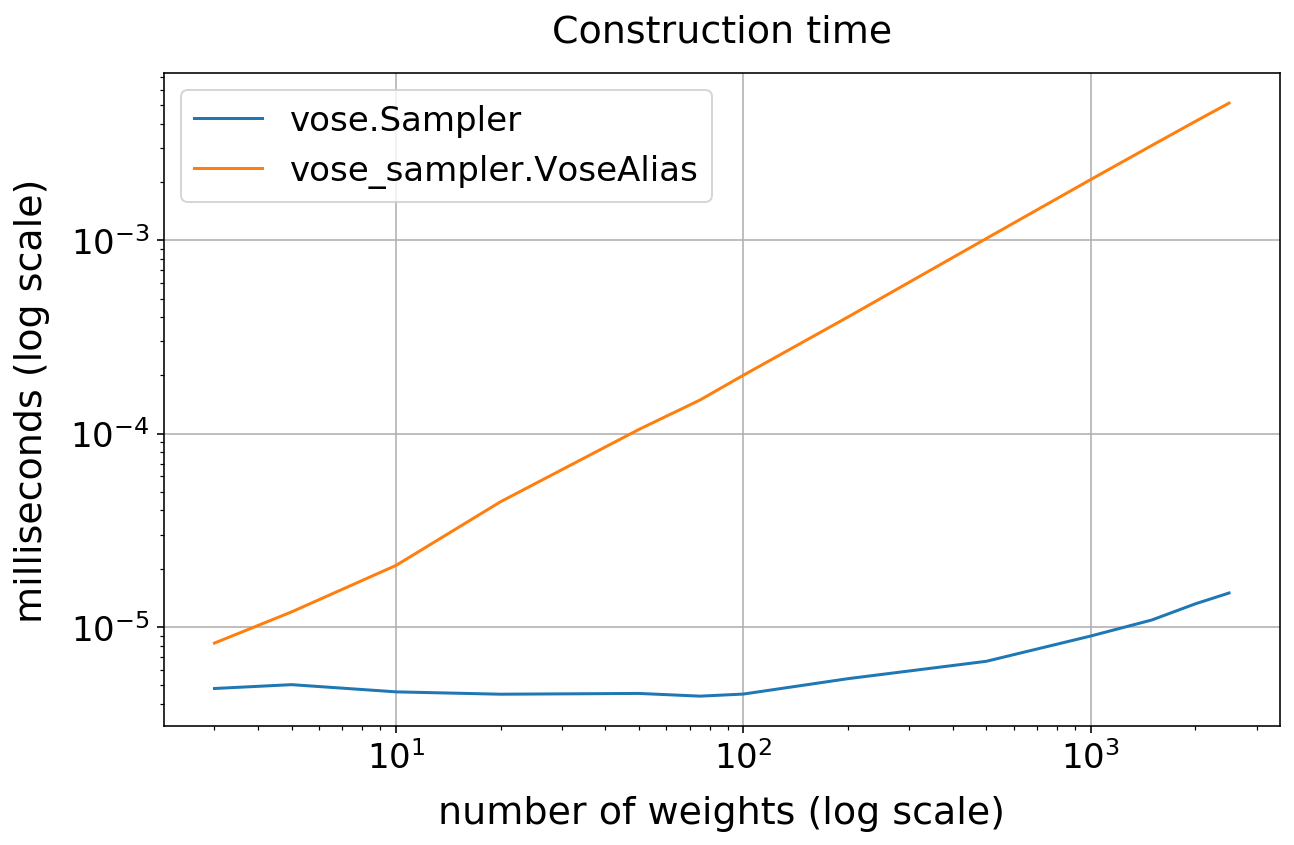

In [4]:
import matplotlib.pyplot as plt
    
fig, ax = plt.subplots(figsize=(10, 6))

for method, g in results.groupby('method'):
    g.plot(x='n', y='time', ax=ax, label=method)

ax.set_title('Construction time', pad=16)
ax.set_xlabel('number of weights (log scale)', labelpad=10)
ax.set_ylabel('milliseconds (log scale)', labelpad=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
fig.savefig('figures/construction_time.svg')

### Sampling time

In [5]:
N = [3, 5, 10, 20, 50, 75, 100, 200, 500, 1000, 1500, 2000, 2500]

results = []

for n in tqdm.tqdm(N):
    
    population = np.arange(n)
    weights = np.random.dirichlet(np.ones(n))
    
    # vose_sampler.VoseAlias
    dist = dict(zip(population, weights))
    sampler = vose_sampler.VoseAlias(dist)
    sims = %timeit -o -q sampler.alias_generation()
    results.append({
        'method': 'vose_sampler.VoseAlias',
        'n': n,
        'time': sims.average
    })
    
    # vose.Sampler
    sampler = vose.Sampler(weights)
    sims = %timeit -o -q sampler.sample()
    results.append({
        'method': 'vose.Sampler',
        'n': n,
        'time': sims.average
    })
    
results = pd.DataFrame(results)
results.head()

100%|██████████| 13/13 [04:27<00:00, 20.59s/it]


,method,n,time
0,vose_sampler.VoseAlias,3,1.699501e-06
1,vose.Sampler,3,7.109697e-08
2,vose_sampler.VoseAlias,5,1.753321e-06
3,vose.Sampler,5,7.825297e-08
4,vose_sampler.VoseAlias,10,1.745214e-06


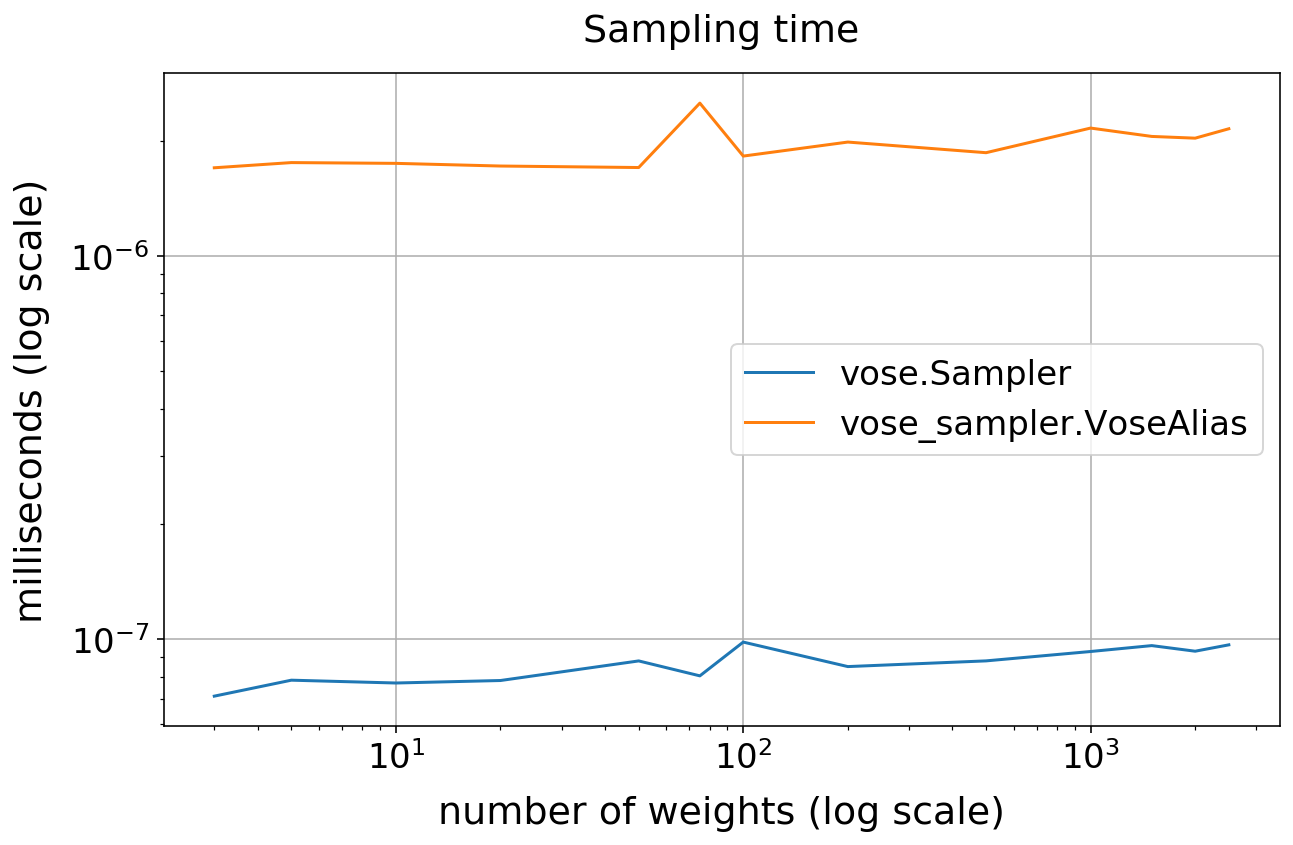

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

for method, g in results.groupby('method'):
    g.plot(x='n', y='time', ax=ax, label=method)

ax.set_title('Sampling time', pad=16)
ax.set_xlabel('number of weights (log scale)', labelpad=10)
ax.set_ylabel('milliseconds (log scale)', labelpad=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid()
fig.savefig('figures/sampling_time.svg')

## Overall comparison

In [7]:
import itertools
import random

import numpy as np
import tqdm
import vose_sampler

N = [3, 30, 300, 3000]
K = [1, 2, 3, 10, 100, 1000]

results = []

for n, k in tqdm.tqdm(list(itertools.product(N, K)), position=0):
    
    population = np.arange(n)
    weights = np.random.dirichlet(np.ones(n))
    
    # np.random.choice
    sims = %timeit -o -q np.random.choice(population, size=k, replace=True, p=weights)
    results.append({
        'method': 'np.random.choice',
        'n': n,
        'k': k,
        'time': sims.average
    })
    
    # random.choices
    sims = %timeit -o -q random.choices(population, weights=weights, k=k)
    results.append({
        'method': 'random.choices',
        'n': n,
        'k': k,
        'time': sims.average
    })
    
    # vose_sampler.VoseAlias
    dist = dict(zip(population, weights))
    sims = %timeit -o -q vose_sampler.VoseAlias(dist).sample_n(size=k)
    results.append({
        'method': 'vose_sampler.VoseAlias',
        'n': n,
        'k': k,
        'time': sims.average
    })
    
    # vose.Sampler
    sims = %timeit -o -q vose.Sampler(weights, copy=False).sample(k=k)
    results.append({
        'method': 'vose.Sampler',
        'n': n,
        'k': k,
        'time': sims.average
    })
    
results = pd.DataFrame(results)

100%|██████████| 24/24 [08:56<00:00, 22.34s/it]


In [8]:
import collections

def format_ms(ms):
    
    ns = ms * 1_000_000

    units = collections.OrderedDict({'ns': 1})
    units['μs'] = 1000 * units['ns']
    units['ms'] = 1000 * units['μs']
    units['s'] = 1000 * units['ms']
    units['m'] = 60 * units['s']
    units['h'] = 60 * units['m']
    units['d'] = 24 * units['h']

    parts = []

    for unit in reversed(units):
        amount = units[unit]
        quotient, ns = divmod(ns, amount)
        if quotient > 0:
            quotient = str(quotient).rstrip('0').rstrip('.')
            parts.append(f'{quotient}{unit}')
        elif ns == 0:
            break

    return ', '.join(parts)

In [9]:
table = pd.pivot_table(results, index=['n', 'k'], columns='method', values='time').applymap(format_ms).reset_index().to_markdown(showindex=False)
print(table)

|    n |    k | np.random.choice   | random.choices   | vose.Sampler   | vose_sampler.VoseAlias   |
|-----:|-----:|:-------------------|:-----------------|:---------------|:-------------------------|
|    3 |    1 | 26ns               | 2ns              | 4ns            | 11ns                     |
|    3 |    2 | 26ns               | 3ns              | 7ns            | 13ns                     |
|    3 |    3 | 26ns               | 3ns              | 7ns            | 14ns                     |
|    3 |   10 | 26ns               | 6ns              | 7ns            | 27ns                     |
|    3 |  100 | 28ns               | 47ns             | 8ns            | 198ns                    |
|    3 | 1000 | 46ns               | 461ns            | 19ns           | 1μs, 887ns               |
|   30 |    1 | 27ns               | 6ns              | 4ns            | 69ns                     |
|   30 |    2 | 26ns               | 7ns              | 7ns            | 73ns                     |
